In [1]:
library(dplyr)
library(ggplot2)
library(readr)
library(stringr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.4.3"


In [2]:
files <- c(
  "Complete_Labeled_Significant_7_1point8_clono.csv",
  "Complete_Labeled_Significant_14_1point8_clono.csv",
  "Complete_Labeled_Significant_7_1point8_pur.csv",
  "Complete_Labeled_Significant_14_1point8_pur.csv",
  "Complete_Labeled_Significant_7_1point8_chae.csv",
  "Complete_Labeled_Significant_14_1point8_chae.csv"
)

dataset_names <- c("Clono_7", "Clono_14", "Purp_7", "Purp_14", "Chae_7", "Chae_14")

target_col <- "npclassifier_superclass"   #column to count

In [3]:
#Optional: nice labels for plots (otherwise uses filename)
labels <- c(
  "(1)Clonostachys – 7 Days",
  "(4)Clonostachys – 14 Days",
  "(3)Purpureocillium – 7 Days",
  "(6)Purpureocillium – 14 Days",
  "(2)Chaetomium – 7 Days",
  "(5)Chaetomium – 14 Days"
)

In [4]:
# ---- READ + COUNT (skipping blanks) ----
freq_list <- lapply(seq_along(files), function(i) {
  df <- read.csv(files[i], stringsAsFactors = FALSE)

  # Skip NA, "", and whitespace-only values
  df_clean <- df %>%
    filter(!is.na(.data[[target_col]])) %>%
    mutate(tmp = str_trim(.data[[target_col]])) %>%
    filter(tmp != "")

  freq <- df_clean %>%
    count(tmp, name = "count") %>%
    arrange(desc(count)) %>%
    mutate(dataset = labels[i]) %>%
    rename(npclassifier_superclass = tmp)

  # Save each frequency table as its own CSV
  out_csv <- paste0(labels[i], "_freq.csv")
  write_csv(freq, out_csv)

  freq
})

freq_all <- bind_rows(freq_list)

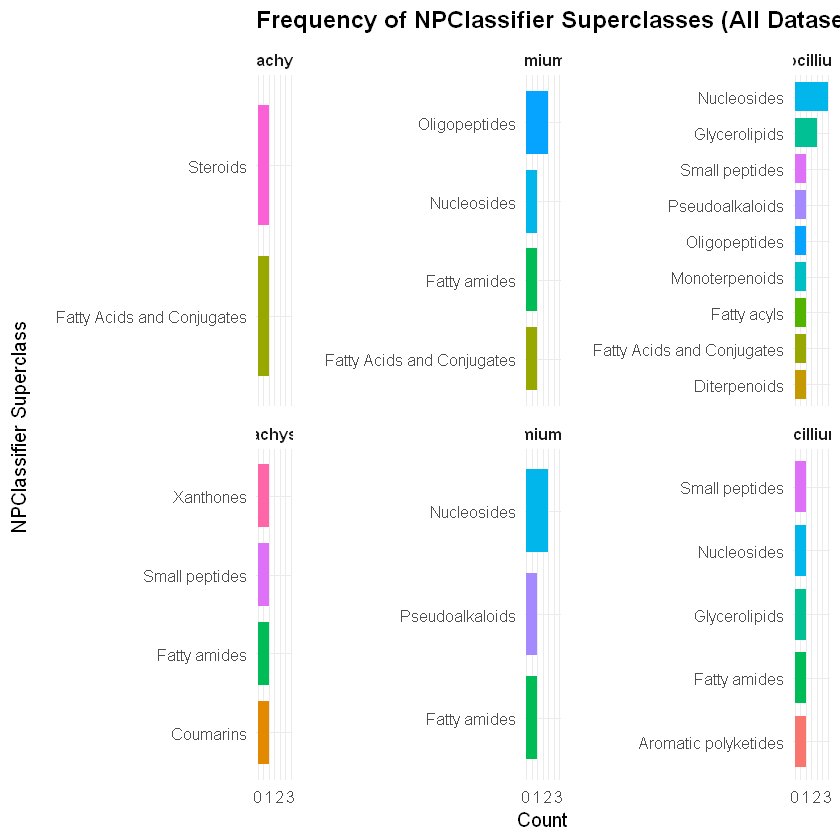

In [5]:
# ---- PLOT: all bar charts in one PNG (facets) ----
# This makes each dataset its own panel.
# Note: reorder_within keeps ordering correct inside each facet.
reorder_within <- function(x, by, within, fun = mean, sep = "___", ...) {
  new_x <- paste(x, within, sep = sep)
  stats::reorder(new_x, by, FUN = fun)
}
scale_y_reordered <- function(..., sep = "___") {
  scale_y_discrete(labels = function(x) gsub(paste0(sep, ".+$"), "", x), ...)
}

p <- ggplot(
  freq_all,
  aes(
    x = count,
    y = reorder_within(npclassifier_superclass, count, dataset),
    fill = npclassifier_superclass
  )
) +
  geom_col(width = 0.8) +
  facet_wrap(~ dataset, scales = "free_y") +
  scale_y_reordered() +
  labs(
    x = "Count",
    y = "NPClassifier Superclass",
    title = "Frequency of NPClassifier Superclasses (All Datasets)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "none",
    plot.title = element_text(face = "bold"),
    strip.text = element_text(face = "bold")
  )

ggsave(
  filename = "npclassifier_superclass_frequencies_all.png",
  plot = p,
  width = 16,
  height = 10,
  dpi = 300
)

print(p)